# LICS Evaluation 
Evaluate different segmentation approaches on the LICS test dataset. These include the deterministic superpixel algorithm, pretrained and finetuned U-Net model. The accuracy, precision, recall, F1 and FOM metrics are calculated. 

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import train
import network
import torch

import augment_data as aug

from scipy.stats import friedmanchisquare,  wilcoxon, kruskal
import scikit_posthocs as sp

import glob

import importlib
import evaluation as eval
import utils
importlib.reload(utils)
importlib.reload(eval)

base_path = '../../data/'

In [2]:
# Model names
none = "DA-NONE-21SEP24.pth"
geo = "DA-GEO-18SEP24.pth" 
noise = "DA-NOISE-18SEP24.pth" 
color = "DA-COLOR-18SEP24.pth"
combine = "DA-COMBINE-18SEP24.pth" #Our proposed approach

ft_none = "FT-NONE-17DEC24.pth"
ft_geo = "FT-GEO-17DEC24.pth"
ft_noise = "FT-NOISE-17DEC24.pth"
ft_color = "FT-COLOR-17DEC24.pth"
ft_combine = "FT-COMBINE-17DEC24.pth"

lics_baseline = "LICS_UNET_12JUL2024.pth" #Pretrained model from previous paper

In [3]:
# Load LICS data
incl_bands = [0,1,2,3,4,5,6]
satellite = 'landsat'

# Test data
target_pos = -2

lics_test_file = base_path + 'LICS/test/'
lics_test_paths = glob.glob(lics_test_file + '*.npy')
lics_test_targets = [np.load(file)[:,:,target_pos] for file in lics_test_paths]
lics_test_input = [np.load(file)[:,:,incl_bands] for file in lics_test_paths]

print("Test dimensions:")
print(np.shape(lics_test_targets))
print(np.shape(lics_test_input))

# Finetune data
target_pos = -1

lics_finetune_file = base_path + 'LICS/finetune/'
lics_finetune_paths = glob.glob(lics_finetune_file + '*.npy')
lics_finetune_targets = [np.load(file)[:,:,target_pos] for file in lics_finetune_paths]
lics_finetune_input = [np.load(file)[:,:,incl_bands] for file in lics_finetune_paths]

print("\nFinetune dimensions:")
print(np.shape(lics_finetune_targets))
print(np.shape(lics_finetune_input))

Test dimensions:
(100, 256, 256)
(100, 256, 256, 7)

Finetune dimensions:
(100, 256, 256)
(100, 256, 256, 7)


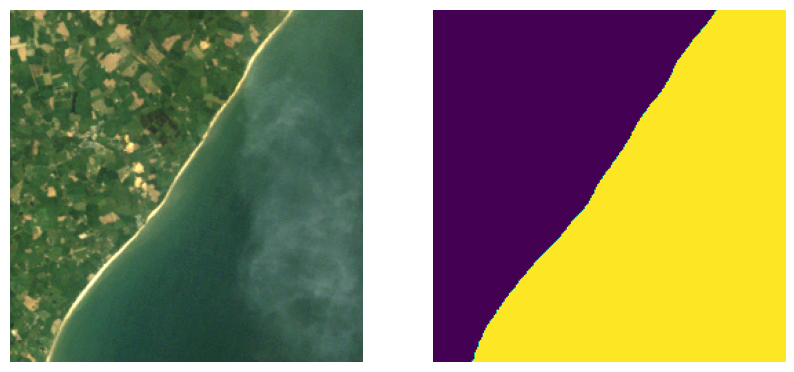

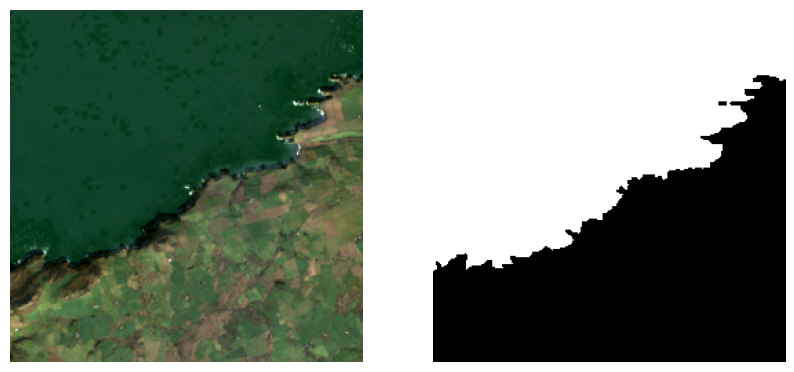

In [4]:
# Test data
i = np.random.randint(0,len(lics_test_paths))
rgb = utils.get_rgb(lics_test_input[i],satellite=satellite,contrast=0.2)
target = lics_test_targets[i]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(rgb)
ax[1].imshow(target)

for a in ax:
    a.axis('off')

# Finetune data
i = np.random.randint(0,len(lics_finetune_paths))
rgb = utils.get_rgb(lics_finetune_input[i],satellite=satellite,contrast=0.2)
target = lics_finetune_targets[i]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(rgb)
ax[1].imshow(target, cmap='gray')

for a in ax:
    a.axis('off')

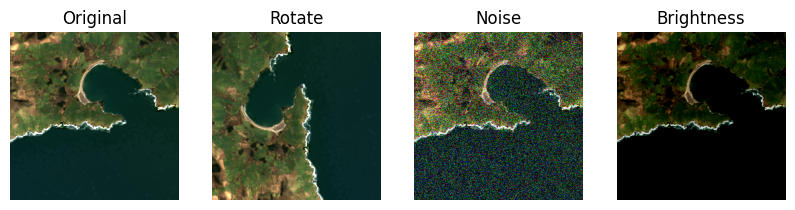

In [73]:
# Example of augmentations
# Test data
i = 41
rgb = utils.get_rgb(lics_test_input[i],satellite=satellite,contrast=0.2)
target = lics_test_targets[i]

fig, ax = plt.subplots(1,4,figsize=(10,5))
ax[0].imshow(rgb)
ax[0].set_title('Original')
ax[1].imshow(aug.rotate(rgb,  90))
ax[1].set_title('Rotate')
ax[2].imshow(aug.add_normal_noise(rgb, 0.2))
ax[2].set_title('Noise')
ax[3].imshow(aug.add_brightness(rgb, -0.2))
ax[3].set_title('Brightness')

for a in ax:
    a.axis('off')

utils.save_fig(fig, 'augmentations')

# Get model results

In [5]:
def model_evaluation(model_name):
    # Set device
    device = torch.device('mps')  #UPDATE
    print("Using device: {}\n".format(device))

    model = network.U_Net(7,2).to(device)

    # Load saved model 
    #model = torch.load('../models/LANDSAT-UNET-20JUL23.pth', map_location=torch.device('cpu') )
    state_dict = torch.load(f'../../models/data_augmentation/{model_name}', map_location=torch.device('cpu') )
    model.load_state_dict(state_dict)
    model.eval()
    model.to(device)

    # Test
    targets, test_preds = eval.get_preds(model,lics_test_paths,target_pos=-2,incl_bands=incl_bands,satellite=satellite,batch_size=10)
    print(len(test_preds))

    test_metrics, test_arr = eval.eval_metrics(lics_test_targets, test_preds)
    eval.display_metrics(test_metrics, test_arr)

    # Finetune
    targets, finetune_preds = eval.get_preds(model,lics_finetune_paths,target_pos=-1,incl_bands=incl_bands,satellite=satellite,batch_size=10)
    print(len(finetune_preds))

    finetune_metrics, finetune_arr = eval.eval_metrics(lics_finetune_targets ,finetune_preds)
  
    return test_preds, test_metrics, test_arr,finetune_metrics

In [6]:
# Ititialize metrics
test_metrics = {}
finetune_metrics = {}

Using device: mps



/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_34057/2634808710.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'../../models/data_

100
accuracy: 95.2733
balanced_accuracy: 95.5799
precision: 94.7017
recall: 94.681
f1: 94.1968
mse: 3.179
fom: 55.8655
100


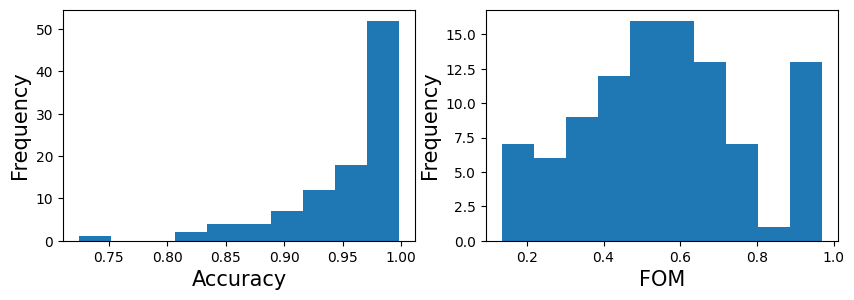

In [7]:
# Fine-tuned model from previous paper
preds, test_metrics['baseline_model'], test_arr, finetune_metrics['baseline_model'] = model_evaluation(lics_baseline)
accuracy_baseline = test_arr['accuracy']


No augmentation
Using device: mps



/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_34057/2634808710.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'../../models/data_

100
accuracy: 94.2051
balanced_accuracy: 93.5725
precision: 98.5659
recall: 87.8796
f1: 91.5543
mse: 3.9225
fom: 53.739
100

Geometric augmentation
Using device: mps

100
accuracy: 99.0653
balanced_accuracy: 99.0099
precision: 99.1068
recall: 98.7691
f1: 98.9316
mse: 1.3795
fom: 86.9385
100

Noise augmentation
Using device: mps

100
accuracy: 98.9218
balanced_accuracy: 98.8799
precision: 98.8669
recall: 98.7021
f1: 98.7755
mse: 1.5142
fom: 82.7862
100

Color augmentation
Using device: mps

100
accuracy: 98.3339
balanced_accuracy: 98.1555
precision: 99.4115
recall: 96.7801
f1: 98.0249
mse: 2.1977
fom: 80.2402
100

Combined augmentation
Using device: mps

100
accuracy: 98.7791
balanced_accuracy: 98.6128
precision: 99.1474
recall: 97.9642
f1: 98.5247
mse: 1.6465
fom: 82.8019
100


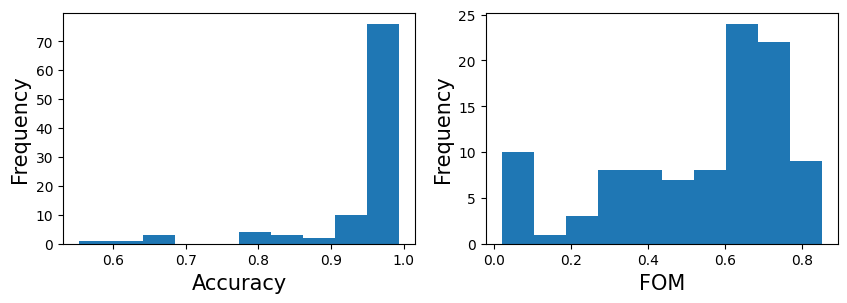

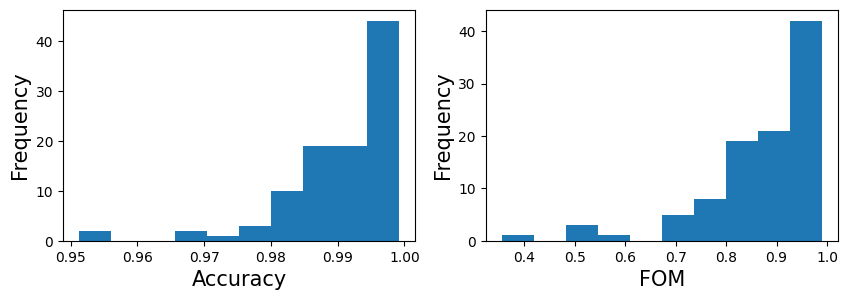

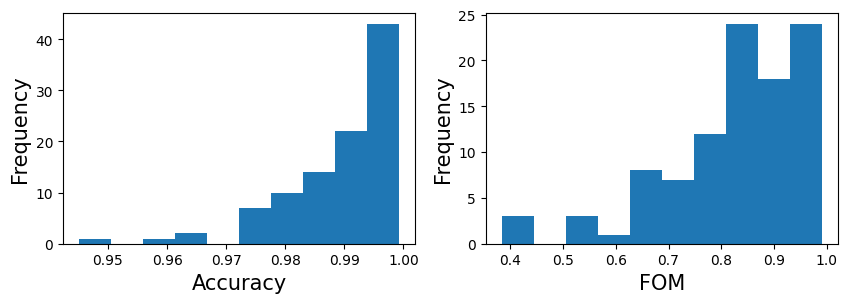

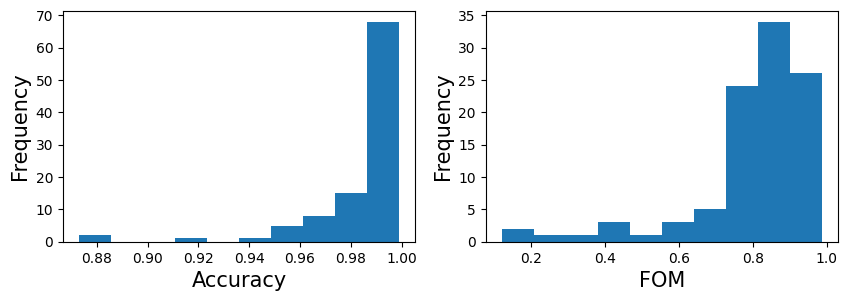

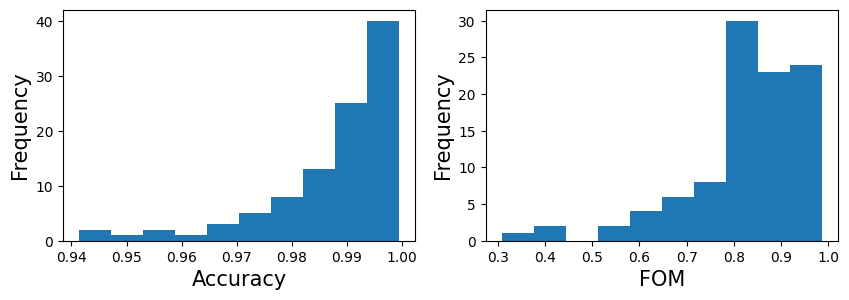

In [8]:
# Models with data augmentation
print("\nNo augmentation")
preds_none, test_metrics['none'], test_arr, finetune_metrics['none'] = model_evaluation(none)
accuracy_none = test_arr['accuracy']

print("\nGeometric augmentation")
preds_geo, test_metrics['geo'],test_arr, finetune_metrics['geo'] = model_evaluation(geo)
accuracy_geo = test_arr['accuracy']

print("\nNoise augmentation")
preds_noise, test_metrics['noise'],test_arr, finetune_metrics['noise'] = model_evaluation(noise)
accuracy_noise = test_arr['accuracy']

print("\nColor augmentation")
preds_color, test_metrics['color'], test_arr,finetune_metrics['color'] = model_evaluation(color)
accuracy_color = test_arr['accuracy']

print("\nCombined augmentation")
preds_combine, test_metrics['combine'],test_arr, finetune_metrics['combine'] = model_evaluation(combine)
accuracy_combine = test_arr['accuracy']



No augmentation
Using device: mps



/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_77397/2634808710.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'../../models/data_

100
accuracy: 98.2329
balanced_accuracy: 97.9353
precision: 98.5752
recall: 97.0679
f1: 97.7548
mse: 2.3122
fom: 77.0496
100

Geometric augmentation
Using device: mps

100
accuracy: 98.8599
balanced_accuracy: 98.7797
precision: 98.7723
recall: 98.5756
f1: 98.6636
mse: 1.7071
fom: 82.2643
100

Noise augmentation
Using device: mps

100
accuracy: 98.5867
balanced_accuracy: 98.382
precision: 99.1486
recall: 97.4742
f1: 98.279
mse: 2.0007
fom: 78.0827
100

Color augmentation
Using device: mps

100
accuracy: 98.4729
balanced_accuracy: 98.3081
precision: 98.4934
recall: 97.9069
f1: 98.1742
mse: 2.0713
fom: 78.4612
100

Combined augmentation
Using device: mps

100
accuracy: 98.8558
balanced_accuracy: 98.7972
precision: 98.9211
recall: 98.4639
f1: 98.682
mse: 1.6569
fom: 81.4076
100


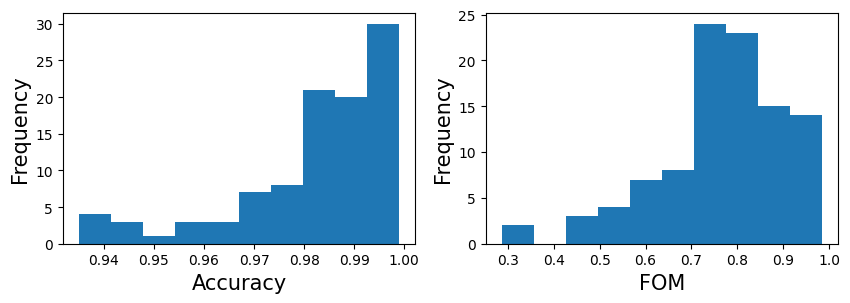

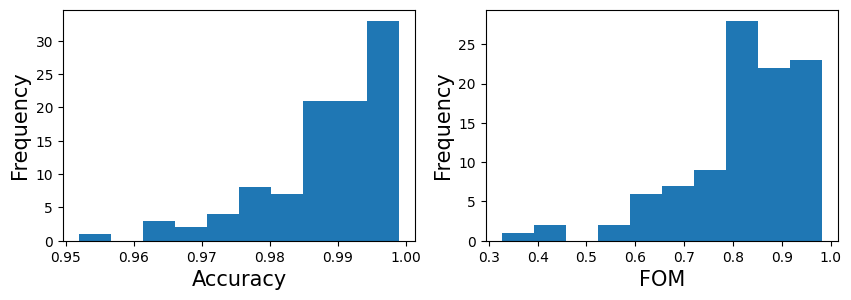

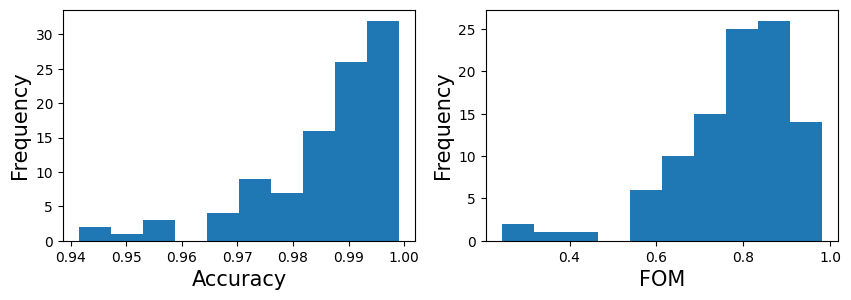

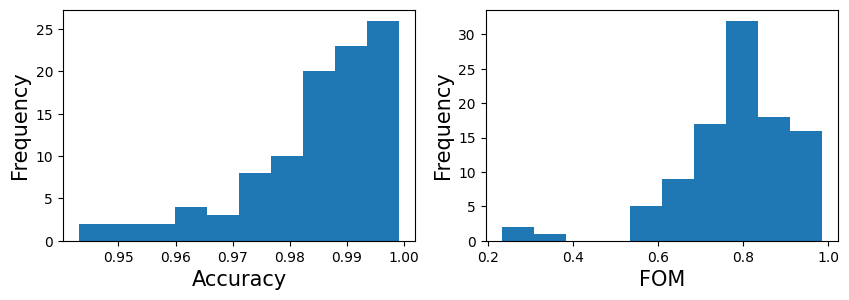

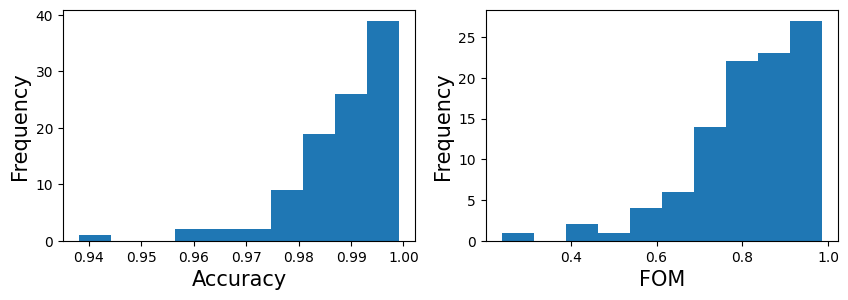

In [12]:
print("\nNo augmentation")
preds_none, test_metrics['ft_none'], test_arr, finetune_metrics['ft_none'] = model_evaluation(ft_none)
ft_accuracy_none = test_arr['accuracy']

print("\nGeometric augmentation")
preds_geo, test_metrics['ft_geo'],test_arr, finetune_metrics['ft_geo'] = model_evaluation(ft_geo)
ft_accuracy_geo = test_arr['accuracy']

print("\nNoise augmentation")
preds_noise, test_metrics['ft_noise'],test_arr, finetune_metrics['ft_noise'] = model_evaluation(ft_noise)
ft_accuracy_noise = test_arr['accuracy']

print("\nColor augmentation")
preds_color, test_metrics['ft_color'], test_arr,finetune_metrics['ft_color'] = model_evaluation(ft_color)
ft_accuracy_color = test_arr['accuracy']

print("\nCombined augmentation")
preds_combine, test_metrics['ft_combine'],test_arr, finetune_metrics['ft_combine'] = model_evaluation(ft_combine)
ft_accuracy_combine = test_arr['accuracy']


# Final Metrics Table

In [13]:
import json

# Save metrics
with open('../data/test_metrics.json', 'w') as f:
    json.dump(test_metrics, f)

with open('../data/finetune_metrics.json', 'w') as f:
    json.dump(finetune_metrics, f)

In [14]:
df_test_metrics = json.load(open('../data/test_metrics.json'))
df_test_metrics = pd.DataFrame(df_test_metrics)

df_test_metrics = df_test_metrics[['baseline_model',
                                   'none', 
                                   'geo', 
                                   'noise', 
                                   'color',
                                   'combine',]]
df_test_metrics = df_test_metrics.transpose()
df_test_metrics = df_test_metrics[['accuracy','precision','recall','f1','fom']]
np.round(df_test_metrics,3)

,accuracy,precision,recall,f1,fom
baseline_model,0.953,0.947,0.947,0.942,0.559
none,0.942,0.986,0.879,0.916,0.537
geo,0.991,0.991,0.988,0.989,0.869
noise,0.989,0.989,0.987,0.988,0.828
color,0.983,0.994,0.968,0.980,0.802
combine,0.988,0.991,0.980,0.985,0.828


In [15]:
# Finetune metrics
df_finetune_metrics = json.load(open('../data/finetune_metrics.json'))
df_finetune_metrics = pd.DataFrame(df_finetune_metrics)

df_finetune_metrics = df_finetune_metrics[['baseline_model','none', 'geo', 'noise', 'color',
       'combine']]
df_finetune_metrics = df_finetune_metrics.transpose()
df_finetune_metrics = df_finetune_metrics[['accuracy','precision','recall','f1','fom']]

np.round(df_finetune_metrics,3)

,accuracy,precision,recall,f1,fom
baseline_model,0.966,0.964,0.964,0.959,0.621
none,0.962,0.986,0.927,0.947,0.576
geo,0.994,0.993,0.993,0.993,0.899
noise,0.992,0.990,0.990,0.990,0.840
color,0.986,0.992,0.976,0.983,0.807
combine,0.990,0.989,0.988,0.988,0.832


In [16]:
accuracy = df_finetune_metrics[['accuracy']]
accuracy['Test'] = df_test_metrics[['accuracy']]
accuracy.columns = ['Finetune','Test']
round(accuracy,3)

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_77397/3607479064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy['Test'] = df_test_metrics[['accuracy']]


,Finetune,Test
baseline_model,0.966,0.953
none,0.962,0.942
geo,0.994,0.991
noise,0.992,0.989
color,0.986,0.983
combine,0.990,0.988


# Visualisations

In [14]:
def display_predcitions(i):
    rgb = utils.get_rgb(lics_test_input[i],satellite=satellite,contrast=0.2)
    target = lics_test_targets[i]

    fig, ax = plt.subplots(1,8,figsize=(20,5))
    ax[0].imshow(rgb)
    ax[1].imshow(target, cmap='gray')
    ax[1].set_title("Ground Truth")

    ax[2].imshow(preds[i], cmap='gray')
    accuracy = np.sum(preds[i] == target) / np.size(target)
    ax[2].set_title("Baseline ({:.3f})".format(accuracy))

    ax[3].imshow(preds_none[i], cmap='gray')
    accuracy = np.sum(preds_none[i] == target) / np.size(target)
    ax[3].set_title("No Aug. ({:.3f})".format(accuracy))

    ax[4].imshow(preds_geo[i], cmap='gray')
    accuracy = np.sum(preds_geo[i] == target) / np.size(target)
    ax[4].set_title("Geometric ({:.3f})".format(accuracy))

    ax[5].imshow(preds_noise[i], cmap='gray')
    accuracy = np.sum(preds_noise[i] == target) / np.size(target)
    ax[5].set_title("Noise ({:.3f})".format(accuracy))

    ax[6].imshow(preds_color[i], cmap='gray')
    accuracy = np.sum(preds_color[i] == target) / np.size(target)
    ax[6].set_title("Color ({:.3f})".format(accuracy))

    ax[7].imshow(preds_combine[i], cmap='gray')
    accuracy = np.sum(preds_combine[i] == target) / np.size(target)
    ax[7].set_title("Combined ({:.3f})".format(accuracy))

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

    utils.save_fig(fig, f'pred_visualisation_{i}')


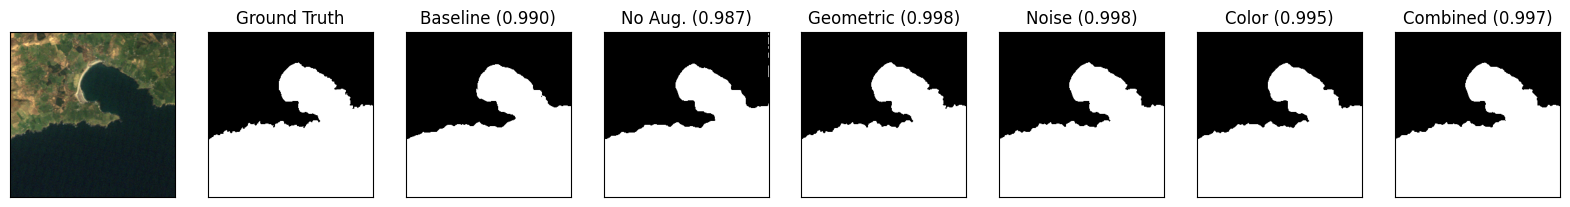

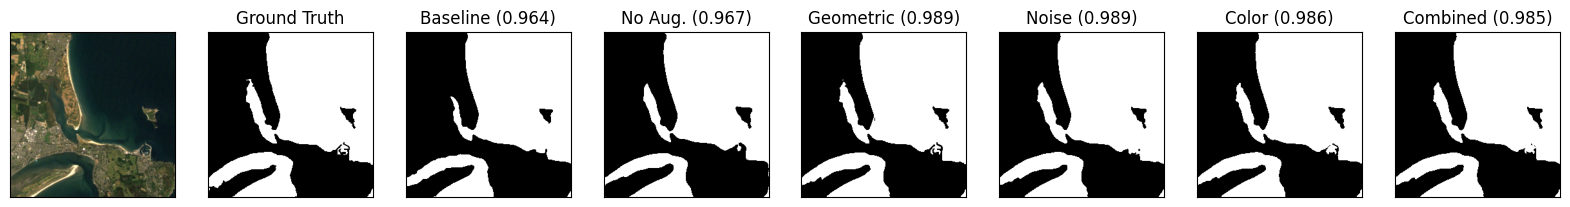

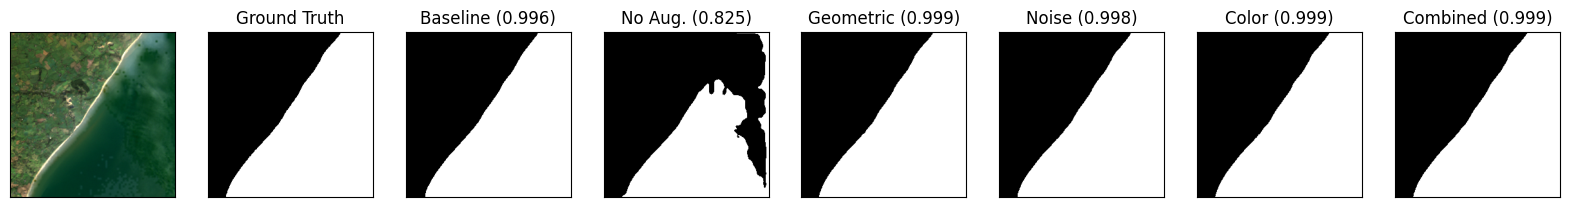

In [15]:
# Display some predictions
display_predcitions(0)
display_predcitions(3)
display_predcitions(5)

# Statistical tests

In [17]:
# Median accuracy
print("Baseline model: \t", np.round(np.median(accuracy_baseline),3))
print("No augmentation: \t", np.round(np.median(accuracy_none),3))
print("Geometric augmentation: ", np.round(np.median(accuracy_geo),3))
print("Noise augmentation: \t", np.round(np.median(accuracy_noise),3))
print("Color augmentation: \t", np.round(np.median(accuracy_color),3))
print("Combined augmentation: \t", np.round(np.median(accuracy_combine),3))

Baseline model: 	 0.973
No augmentation: 	 0.974
Geometric augmentation:  0.994
Noise augmentation: 	 0.993
Color augmentation: 	 0.989
Combined augmentation: 	 0.992


In [18]:
# Perform Friedman test
stat, p_value = friedmanchisquare(accuracy_geo, accuracy_noise, accuracy_color, accuracy_combine)

print(f'Friedman Test Statistic: {stat}')
print(f'P-Value: {p_value}')

Friedman Test Statistic: 58.460843373494065
P-Value: 1.2531663175120488e-12


In [20]:
# Wilcoxon signed-rank test
labels = ['No Augmentation', 'Noise', 'Colour', 'Combined']
for i, acc in enumerate([accuracy_none, accuracy_noise, accuracy_color, accuracy_combine]):
    stat, p_value = wilcoxon(accuracy_geo, acc)
    print(f'{labels[i]}: {np.round(p_value,6)}')

No Augmentation: 0.0
Noise: 2e-05
Colour: 0.0
Combined: 1e-06


## Finetuning metrics

In [23]:
df_test_metrics = json.load(open('../data/test_metrics.json'))
df_test_metrics = pd.DataFrame(df_test_metrics)

df_test_metrics = df_test_metrics[['baseline_model',
                                   'none', 'ft_none',
                                   'geo', 'ft_geo'
                                   ]]
df_test_metrics = df_test_metrics.transpose()
df_test_metrics = df_test_metrics[['accuracy','precision','recall','f1','fom']]
np.round(df_test_metrics,3)

,accuracy,precision,recall,f1,fom
baseline_model,0.953,0.947,0.947,0.942,0.559
none,0.942,0.986,0.879,0.916,0.537
ft_none,0.982,0.986,0.971,0.978,0.770
geo,0.991,0.991,0.988,0.989,0.869
ft_geo,0.989,0.988,0.986,0.987,0.823


In [25]:
# Wilcoxon signed-rank test
stat, p_value = wilcoxon(accuracy_geo, ft_accuracy_geo)
print(f'Geometric: {np.round(p_value,6)}')

Geometric: 0.0
